# TreeDataset and WasmTree evaluation as an RDF.JS implementation

## Import libraries and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from pytreemap import TreeMap
import pprint as pp
import statistics 

import wasmtreeplot

plt.rcParams["figure.figsize"]=5,5

In [2]:
# { 'S' : { (tool, dataset) : { size : [ { match : T , load : T }, ...], ... } }  , 'POG' : ... }
match_data       = wasmtreeplot.load_query_measures("measures_query.csv")
repartition_data = wasmtreeplot.load_query_measures("measures_split.csv")

# { (dataset, nbOftrees) : [ { "memory" : T, "time" : T }, ... ] }
load_data        = wasmtreeplot.load_initialization_measures("measures_init.csv")


In [3]:
reduce_match_data, _            = wasmtreeplot.reduce_query_data(match_data)
split_data, split_stdev         = wasmtreeplot.reduce_query_data(repartition_data)
reduce_load_data, loading_speed = wasmtreeplot.reduce_loading(load_data)

In [4]:
print(wasmtreeplot.memory_as_string(reduce_load_data))


('graphy', 1) => {memory=595808.9565217391, time=5.641577076608861}
('tree', 6) => {memory=30994.782608695652, time=12.967600476956443}
('tree', 1) => {memory=30991.565217391304, time=10.809878231869705}
('n3', 3) => {memory=1287200.4347826086, time=6.960175167891278}
('wasm_tree', 6) => {memory=407496.60869565216, time=7.4393268644131085}
('wasm_tree', 1) => {memory=411076.8695652174, time=5.331066180434704}


## Loading speed bar plot

For some RDF.JS dataset implementation, and N3.js, display the loading speed, which is the time per quad added in the dataset (for a dataset of 1M quads)

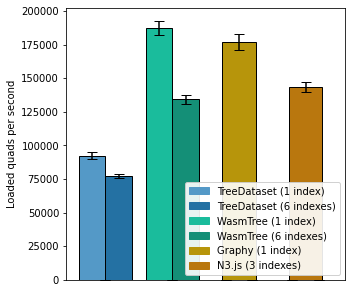

In [5]:
wasmtreeplot.loading_boxplot(loading_speed, [
    ("tree"     , "TreeDataset", "#5499c7", "#2471a3", "yellow"),
    ("wasm_tree", "WasmTree"   , "#1abc9c", "#148f77", "yellow"),
    ("graphy"   , "Graphy"     , "yellow" , "yellow" , "#b7950b"),
    ("n3"       , "N3.js"      , "yellow" , "yellow" , "#b9770e")
])

## match time depending on the RDF.JS Dataset and the size of the input dataset

In [6]:
datasets = [
    ("rdfjsdataset", "wrap_tree", "TreeDataset (All-at-once)", "-", 'P'),
    ("rdfjsdataset", "tree", "TreeDataset (Naive)", "-", "d"),
    ("rdfjsdataset", "graphy", "Graphy", ":", "*"),
    ("rdfjsdataset", "wasm_tree", "WasmTree", "-", 'x')
]

stores = [
    ("rdfjsstore", "n3"       , "n3.js"   , "--", "D"),
    ("rdfjsstore", "wasm_tree", "WasmTree", "-", 'x')
]

===== RDF.JS DATASET: all quads with a defined Subject


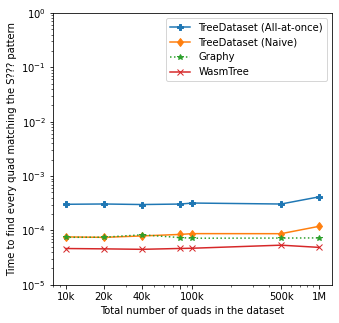

===== RDF.JS DATASET: all quads with a defined predicate, object and graph


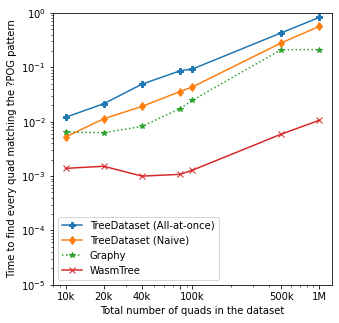

===== RDF.JS STORE: all quads with a defined Subject


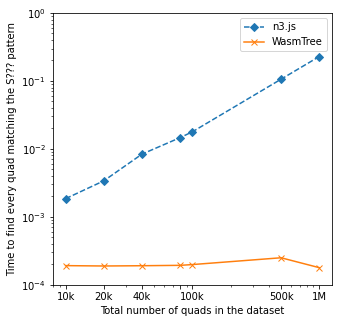

===== RDF.JS STORE: all quads with a defined predicate, object and graph


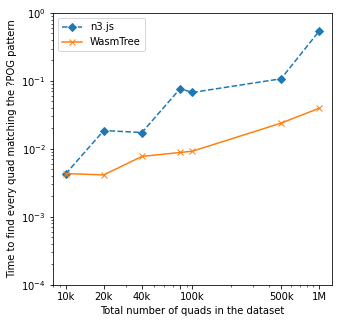

In [7]:
print("===== RDF.JS DATASET: all quads with a defined Subject")
wasmtreeplot.simple_plot(reduce_match_data['S']  , datasets, 10**-5, 1, "S???")

print("===== RDF.JS DATASET: all quads with a defined predicate, object and graph")
wasmtreeplot.simple_plot(reduce_match_data['POG'], datasets, 10**-5, 1, "?POG")

print("===== RDF.JS STORE: all quads with a defined Subject")
wasmtreeplot.simple_plot(reduce_match_data['S']  , stores  , 10**-4, 1, "S???")

print("===== RDF.JS STORE: all quads with a defined predicate, object and graph")
wasmtreeplot.simple_plot(reduce_match_data['POG'], stores  , 10**-4, 1, "?POG")

In [8]:
print("-- From N3")
wasmtreeplot.difference(reduce_match_data, "S", "rdfjsstore", "n3")
wasmtreeplot.difference(reduce_match_data, "POG", "rdfjsstore", "n3")
print("-- From itself")
wasmtreeplot.difference(reduce_match_data, "S", "rdfjsstore", "wasm_tree", "rdfjsdataset")
wasmtreeplot.difference(reduce_match_data, "POG", "rdfjsstore", "wasm_tree", "rdfjsdataset")

-- From N3
For S Wasm tree is 9.674 to 1278.741 faster than n3
For POG Wasm tree is 0.987 to 13.671 faster than n3
-- From itself
For S Wasm tree is 3.666 to 4.664 faster than wasm_tree
For POG Wasm tree is 2.732 to 8.220 faster than wasm_tree


## Repartition study and ablation test (on 1M quads)

*Erratum: The preprint bar plots for repartition have a scale that is divided 1024. The cloud of dots plots and the bar plots in this notebook have the correct scale.*

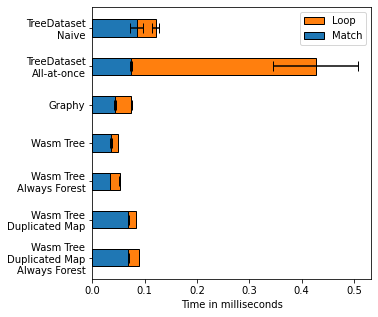

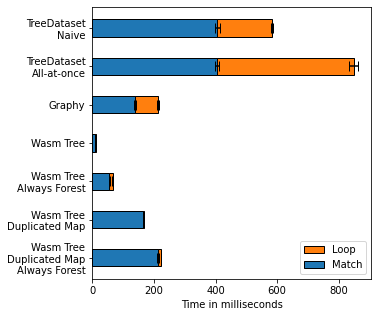

In [9]:
datasets = [
    ("rdfjsdataset", "tree", "TreeDataset\nNaive", "-"),
    ("rdfjsdataset", "wrap_tree", "TreeDataset\nAll-at-once", "-"),
    ("rdfjsdataset", "graphy", "Graphy", ":"),
    ("rdfjsdataset", "wasm_tree", "Wasm Tree", "-"),
    ("rdfjsdataset", "wasm_tree_FS", "Wasm Tree\nAlways Forest"),
    ("rdfjsdataset", "wasm_tree_II", "Wasm Tree\nDuplicated Map"),
    ("rdfjsdataset", "wasm_tree_FI", "Wasm Tree\nDuplicated Map\nAlways Forest")
]

wasmtreeplot.repartition(split_stdev['S']  , datasets)
wasmtreeplot.repartition(split_stdev['POG'], datasets)